# Assignment 3 Notebook #

This notebook focuses on looking at the quality of different wines.

Dataset source: https://datarepository.wolframcloud.com/resources/Sample-Data-Wine-Quality

The code in this notebook had been adapted partially from [the week 6 class jupyter notebook](https://git.arts.ac.uk/lmccallum/Intro-to-DS-2022/blob/master/Week%206/Intro%20to%20Data%20Science%20Assignment%203%20-%20Clustering_Data.ipynb).

In [12]:
#!pip install keras

In [11]:
#!pip install tensorflow

In [1]:
## IMPORT CELL ##
import random, os, sys, shutil
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
import keras
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## STEP 1: Load Dataset into Notebook ##

The wine quality dataset will be loaded in, where it will be checked prior to any clustering analysis.

In [2]:
#Read in csv file
df = pd.read_csv("data/Wine_Quality.csv")

In [3]:
#See columns of the dataset
df.columns

Index(['WineQuality', 'FixedAcidity', 'VolatileAcidity', 'CitricAcid',
       'ResidualSugar', 'Chlorides', 'FreeSulfurDioxide', 'TotalSulfurDioxide',
       'Density', 'PH', 'Sulphates', 'Alcohol'],
      dtype='object')

In [4]:
#Summarise the variable data
df.describe()

,WineQuality,FixedAcidity,VolatileAcidity,CitricAcid,ResidualSugar,Chlorides,FreeSulfurDioxide,TotalSulfurDioxide,Density,PH,Sulphates,Alcohol
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,5.877909,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267
std,0.885639,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621
min,3.000000,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000
25%,5.000000,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000
50%,6.000000,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000
75%,6.000000,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000
max,9.000000,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000


In [5]:
df.isna().any()

WineQuality           False
FixedAcidity          False
VolatileAcidity       False
CitricAcid            False
ResidualSugar         False
Chlorides             False
FreeSulfurDioxide     False
TotalSulfurDioxide    False
Density               False
PH                    False
Sulphates             False
Alcohol               False
dtype: bool

From the cell above, the dataset contains no NaN values in any of the columns. This means that the state of the dataset is sufficient for clustering.

## STEP 2: Correlation and Standardisation

Before clustering our wine dataset, we can check which variables are correlated with one another by constructing a correlation matrix.

In [6]:
#Use built-in df.corr function to build correlation matrix
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

C:\Users\tcelu\AppData\Local\Temp\ipykernel_22956\915133135.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,WineQuality,FixedAcidity,VolatileAcidity,CitricAcid,ResidualSugar,Chlorides,FreeSulfurDioxide,TotalSulfurDioxide,Density,PH,Sulphates,Alcohol
WineQuality,1.00,-0.11,-0.19,-0.01,-0.10,-0.21,0.01,-0.17,-0.31,0.10,0.05,0.44
FixedAcidity,-0.11,1.00,-0.02,0.29,0.09,0.02,-0.05,0.09,0.27,-0.43,-0.02,-0.12
VolatileAcidity,-0.19,-0.02,1.00,-0.15,0.06,0.07,-0.10,0.09,0.03,-0.03,-0.04,0.07
CitricAcid,-0.01,0.29,-0.15,1.00,0.09,0.11,0.09,0.12,0.15,-0.16,0.06,-0.08
ResidualSugar,-0.10,0.09,0.06,0.09,1.00,0.09,0.30,0.40,0.84,-0.19,-0.03,-0.45
Chlorides,-0.21,0.02,0.07,0.11,0.09,1.00,0.10,0.20,0.26,-0.09,0.02,-0.36
FreeSulfurDioxide,0.01,-0.05,-0.10,0.09,0.30,0.10,1.00,0.62,0.29,-0.00,0.06,-0.25
TotalSulfurDioxide,-0.17,0.09,0.09,0.12,0.40,0.20,0.62,1.00,0.53,0.00,0.13,-0.45
Density,-0.31,0.27,0.03,0.15,0.84,0.26,0.29,0.53,1.00,-0.09,0.07,-0.78
PH,0.10,-0.43,-0.03,-0.16,-0.19,-0.09,-0.00,0.00,-0.09,1.00,0.16,0.12


The closer the value is to 1, the stronger the positive correlation between the variables. The following are the pairs of variables with considerably strong correlation:
 - ResidualSugar and Density (0.84)
 - FreeSulfurDioxide and TotalSulfurDioxide (0.62)
 - TotalSulfurDioxide and Density (0.53)
 - WineQuality and Alcohol (0.44)

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Next is to standardise the variables; as all the variables are numeric, there does not seem to be a reason to drop any columns.

In [8]:
#standardise the variables
x = df
x = StandardScaler().fit_transform(x)

## STEP 3: Principal Component Analysis (PCA) ##

Perform PCA on the dataset to reduce it's dimensionality.

In [9]:
#Reduce dataset dimensions
pca = PCA(n_components=2)
x_2d = pca.fit_transform(x)

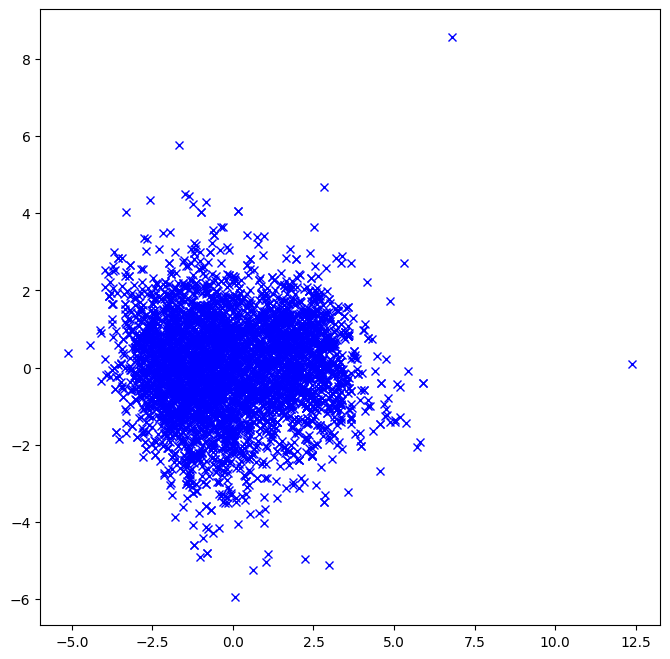

In [10]:
#Plot PCA 
plt.figure(figsize=(8, 8))
a = plt.plot(x_2d[:,0],x_2d[:,1],"bx")

From doing PCA, there does not seem to be any distinct groups in the data. In fact, they all converge into one group, save for a few outliers.

In [11]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='r', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_clusters(clusterer, X):
    labels = clusterer.predict(X)
    pca = PCA(n_components=2)
    x_2d = pca.fit_transform(X)
    plt.scatter(x_2d[:, 0], x_2d[:, 1], c=labels, alpha=0.3)
    plot_centroids(clusterer.cluster_centers_)

## STEP 3: K-Means clustering

As we have standardised the data and performed PCA, we can now perform k-means clustering on the data. Firstly, we need to use an elbow plot to check for the optimal value of k.

C:\Users\tcelu\miniconda3\envs\introds\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\tcelu\miniconda3\envs\introds\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\tcelu\miniconda3\envs\introds\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\tcelu\miniconda3\envs\introds\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


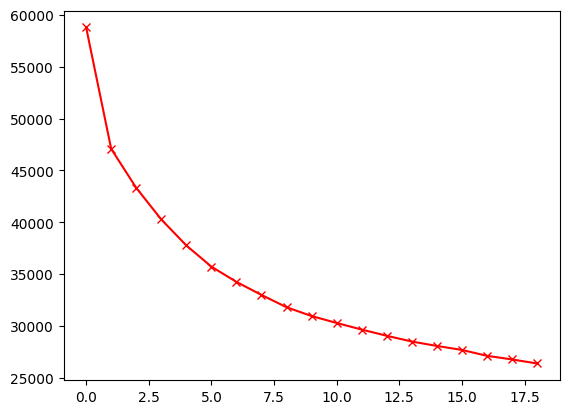

In [12]:
#Plot an elbow plot to find the best value of k within the range of 1 to 20.
scores=[]
for i in range(1,20):
    #Fit for k
    means=KMeans(n_clusters=i)
    means.fit(x)
    #Get inertia
    scores.append(means.inertia_)
plt.plot(scores,"-rx")

Looking at the elbow plot, we can see that the inertia begins to decrease in a linear fashion from k=5. However, we can still test k values in the range of 5 to 8 to see which one ends up being the best.

C:\Users\tcelu\miniconda3\envs\introds\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


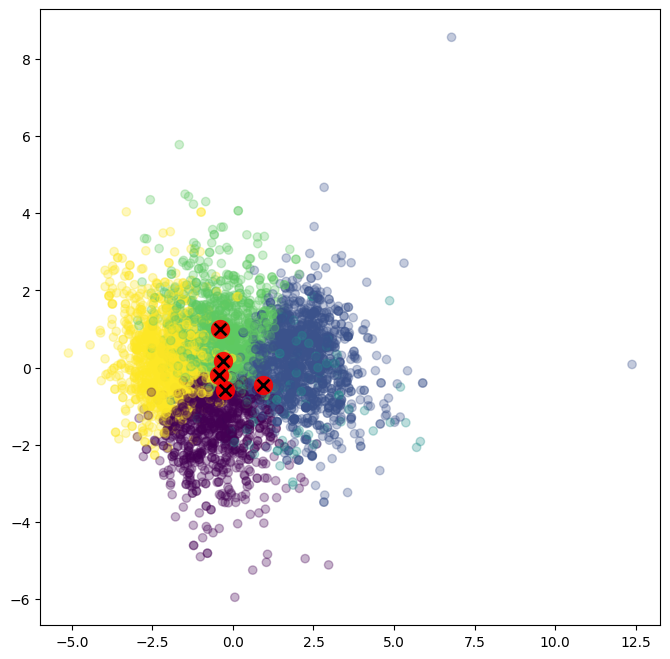

In [13]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(x)
plt.figure(figsize=(8, 8))
#Plot clusters onto PCA reduced plot
plot_clusters(kmeans, x)

C:\Users\tcelu\miniconda3\envs\introds\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


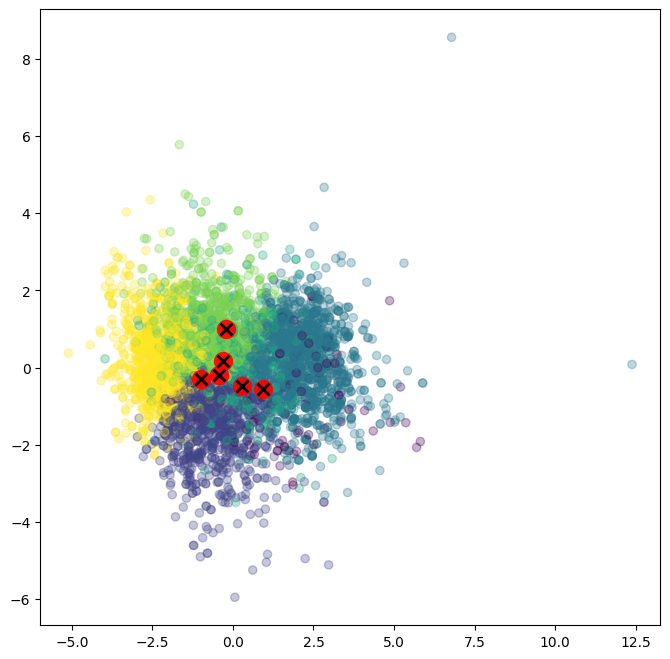

In [14]:
k = 6
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(x)
plt.figure(figsize=(8, 8))
#Plot clusters onto PCA reduced plot
plot_clusters(kmeans, x)

C:\Users\tcelu\miniconda3\envs\introds\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


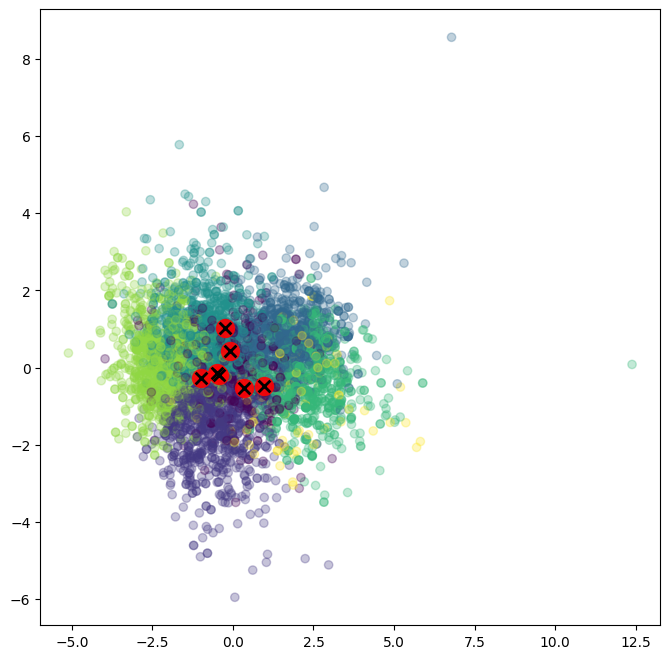

In [15]:
k = 7
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(x)
plt.figure(figsize=(8, 8))
#Plot clusters onto PCA reduced plot
plot_clusters(kmeans, x)

The first few k-means clusterings were done on all the features (i.e. not taking into account PCA). The clustering was done with k = 5,6 and 7. From the plots, it is clear that, in the case of full dimensionality, that k=5 gives the clearest clustering results (somewhat hard clustering). Anything beyond 5 causes the clusters to seep into one another.

Now we will test k-means clustering on the data with reduced dimensionality.

C:\Users\tcelu\miniconda3\envs\introds\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


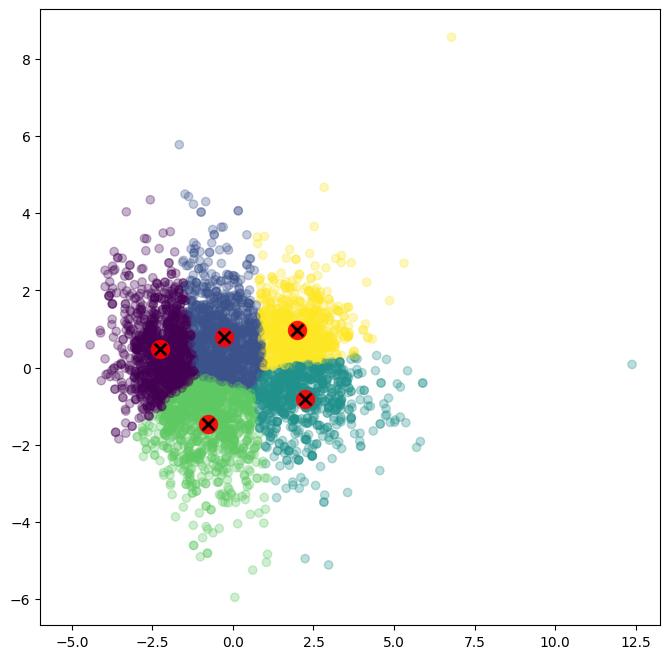

In [23]:
#How many dimensions to reduce to (before clustering)?
num_dimensions = 2 

#What value of k (how many clusters)?
k=5

#Reduce dimensions
pca = PCA(n_components=num_dimensions)
x_less_dimensions = pca.fit_transform(x)

#Fit cluster
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(x_less_dimensions)

#Plot results on 2D plot
plt.figure(figsize=(8, 8))
plot_clusters(kmeans, x_less_dimensions)

C:\Users\tcelu\miniconda3\envs\introds\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


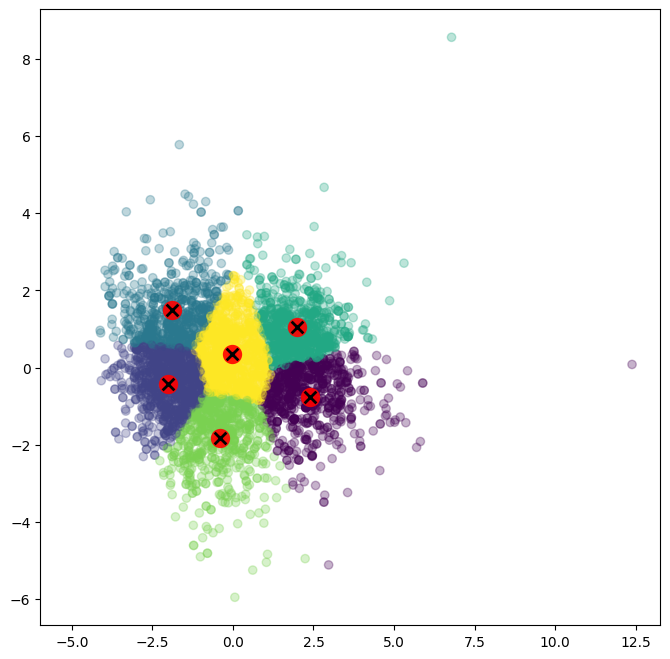

In [21]:
#How many dimensions to reduce to (before clustering)?
num_dimensions = 2 

#What value of k (how many clusters)?
k=6

#Reduce dimensions
pca = PCA(n_components=num_dimensions)
x_less_dimensions = pca.fit_transform(x)

#Fit cluster
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(x_less_dimensions)

#Plot results on 2D plot
plt.figure(figsize=(8, 8))
plot_clusters(kmeans, x_less_dimensions)

C:\Users\tcelu\miniconda3\envs\introds\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


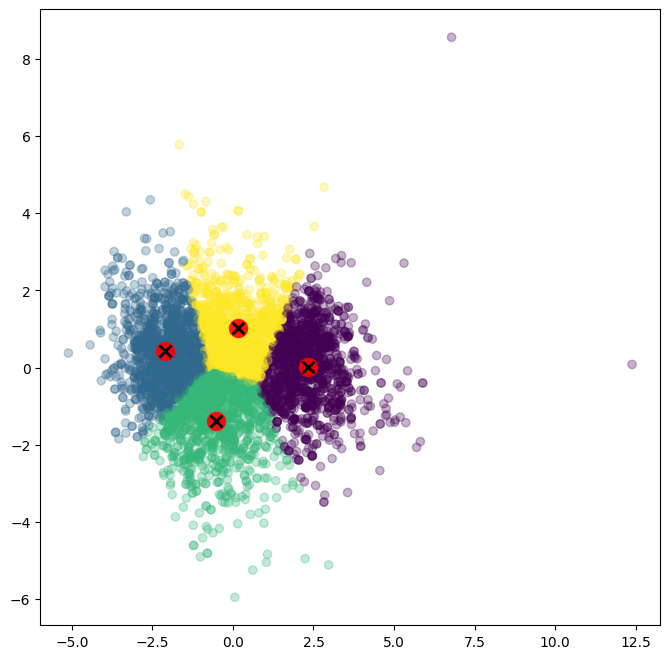

In [22]:
#How many dimensions to reduce to (before clustering)?
num_dimensions = 2 

#What value of k (how many clusters)?
k=4

#Reduce dimensions
pca = PCA(n_components=num_dimensions)
x_less_dimensions = pca.fit_transform(x)

#Fit cluster
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(x_less_dimensions)

#Plot results on 2D plot
plt.figure(figsize=(8, 8))
plot_clusters(kmeans, x_less_dimensions)

With the dimensions reduced, we get much clearer clusters of the data. Just like before, it seems that k=5 is the most appropriate number of clusters for this dataset. Using more than 5 doesn't add much to our understanding of the data and any k value less than 5 causes the clusters to seep into each other a little bit.

## STEP 4: Examining the Clusters

Now that we have our k clusters, it is best to check them against certain features of the data; that way, we can try and figure out what each cluster means.

C:\Users\tcelu\miniconda3\envs\introds\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0.5, 0, 'cluster number')

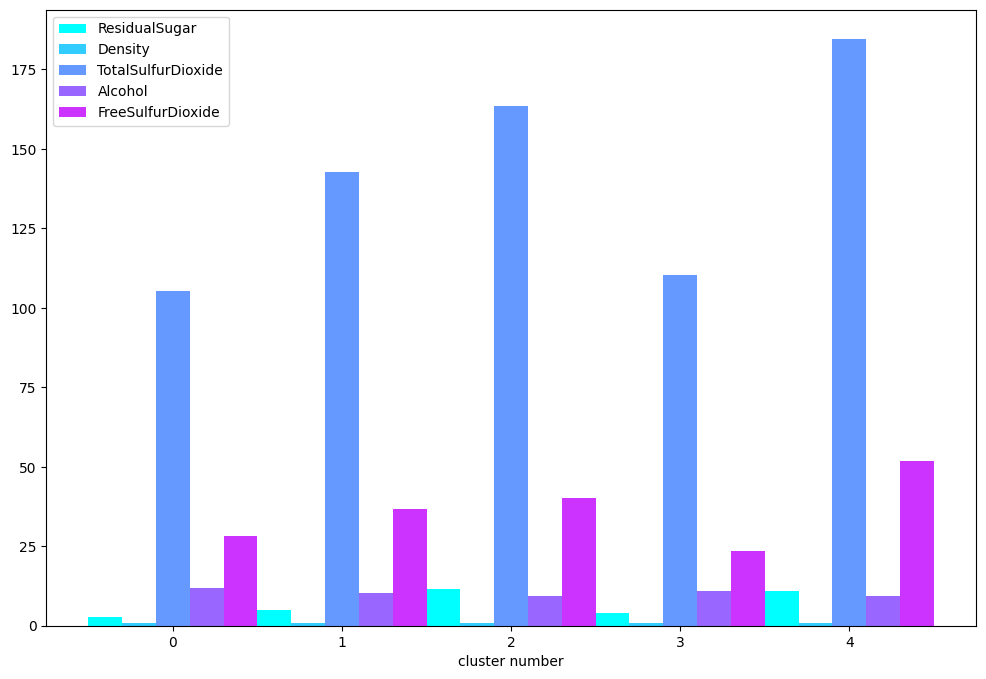

In [25]:
#Fit clusters
k=5
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(x_less_dimensions)

                                    ### ATTEMPT 1 ###

#Add cluster labels as extra column in dataframe
labels = kmeans.predict(x_less_dimensions)
df["cluster"] = labels

#Pick some features to plot
features = ['ResidualSugar', 'Density', 'TotalSulfurDioxide', 'Alcohol', 'FreeSulfurDioxide']
width = 1/(len(features))

fig,ax = plt.subplots(figsize=(12, 8))

for i in range(k):
    ax.bar([i],[1],width=width*4,color = "azure" if i%2==0 else "whitesmoke")

cmap = plt.cm.get_cmap('cool')
#Iterate through features
for index, f in enumerate(features):
    #Get mean for each feature for each cluster
    data = [np.mean(df[df["cluster"]==i][f]) for i in range(k)]
    
    x_vals = np.arange(len(data)) + (width*index) - 0.5 + width/2
    
    #Plot this feature for each cluster
    ax.bar(x_vals, data, width = width, label = f, color = cmap(index/len(features)))
    
ax.legend()
ax.set_xlabel("cluster number")

Text(0.5, 0, 'cluster number')

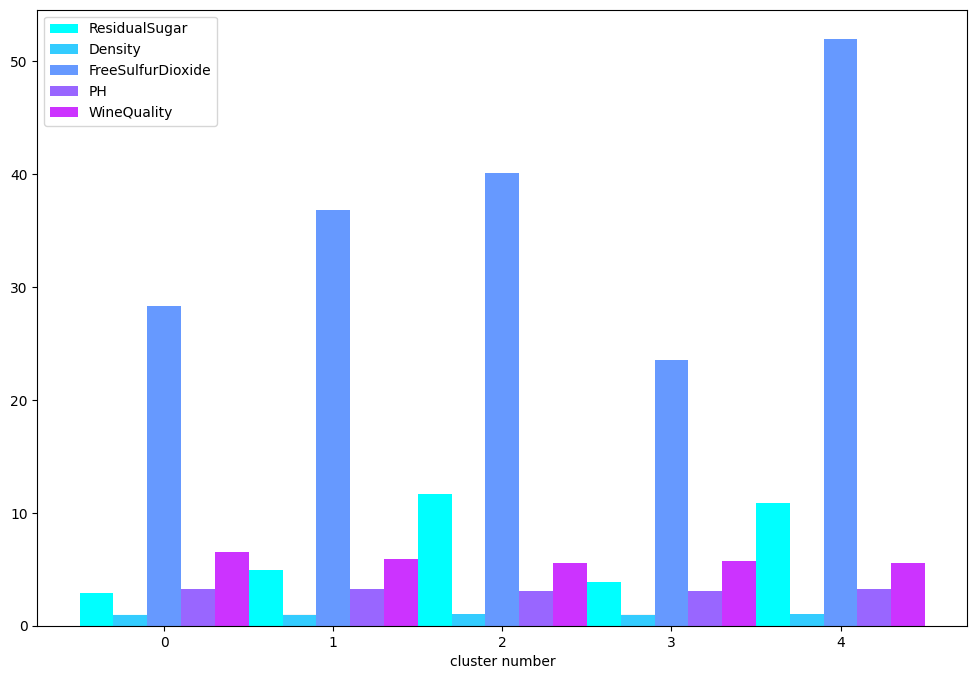

In [27]:
                                    ### ATTEMPT 2 ###


#Add cluster labels as extra column in dataframe
labels = kmeans.predict(x_less_dimensions)
df["cluster"] = labels

#Pick some features to plot
features = ['ResidualSugar', 'Density', 'FreeSulfurDioxide', 'PH', 'WineQuality']
width = 1/(len(features))

fig,ax = plt.subplots(figsize=(12, 8))

for i in range(k):
    ax.bar([i],[1],width=width*4,color = "azure" if i%2==0 else "whitesmoke")

cmap = plt.cm.get_cmap('cool')
#Iterate through features
for index, f in enumerate(features):
    #Get mean for each feature for each cluster
    data = [np.mean(df[df["cluster"]==i][f]) for i in range(k)]
    
    x_vals = np.arange(len(data)) + (width*index) - 0.5 + width/2
    
    #Plot this feature for each cluster
    ax.bar(x_vals, data, width = width, label = f, color = cmap(index/len(features)))
    
ax.legend()
ax.set_xlabel("cluster number")

Text(0.5, 0, 'cluster number')

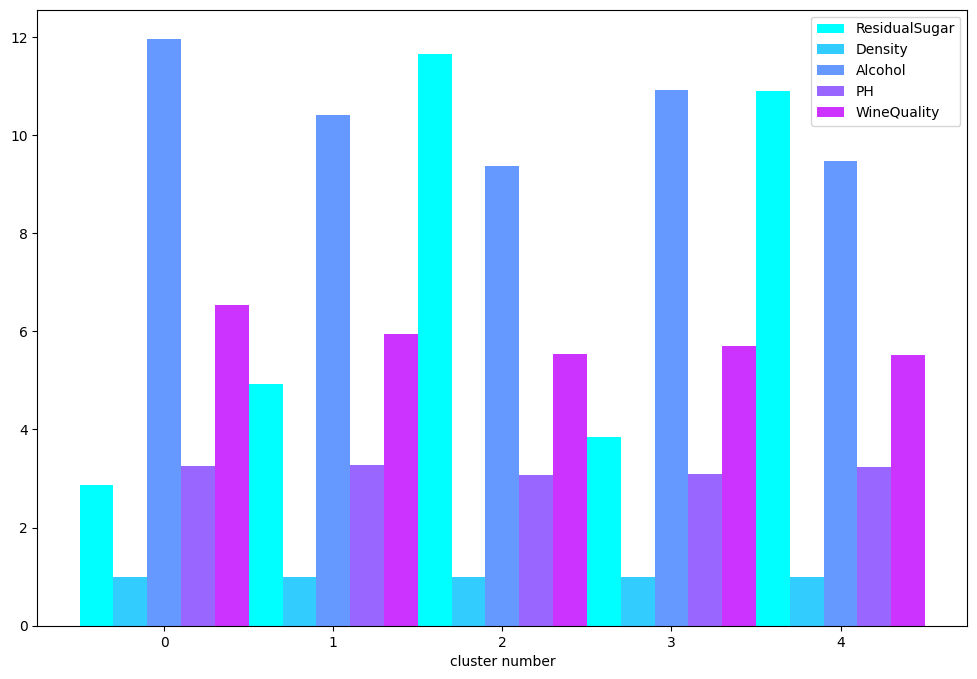

In [28]:
                                    ### ATTEMPT 3 ###


#Add cluster labels as extra column in dataframe
labels = kmeans.predict(x_less_dimensions)
df["cluster"] = labels

#Pick some features to plot
features = ['ResidualSugar', 'Density', 'Alcohol', 'PH', 'WineQuality']
width = 1/(len(features))

fig,ax = plt.subplots(figsize=(12, 8))

for i in range(k):
    ax.bar([i],[1],width=width*4,color = "azure" if i%2==0 else "whitesmoke")

cmap = plt.cm.get_cmap('cool')
#Iterate through features
for index, f in enumerate(features):
    #Get mean for each feature for each cluster
    data = [np.mean(df[df["cluster"]==i][f]) for i in range(k)]
    
    x_vals = np.arange(len(data)) + (width*index) - 0.5 + width/2
    
    #Plot this feature for each cluster
    ax.bar(x_vals, data, width = width, label = f, color = cmap(index/len(features)))
    
ax.legend()
ax.set_xlabel("cluster number")

In the first attempt, by looking at the highest correlated variables, it seems that the clusters were created based on a range of the level of total sulfur dioxide in the wines - this is only because the means of this variable were considerably high in each cluster.

In the second attempt, the clusters could have been formed by the same criteria but this time it's ranges of the level of _free_ sulfur dioxide in each wine. Finally, in the third attempt, there isn't really one variable that has the highest mean in each cluster. Clusters could have been formed by either the range of alcohol levels in each wine (in which case, clusters are distinguished by how strong they are). An equally likely criteria could be by the level of residual sugars in each wine (each cluster measured by levels of sweetness?).